In [187]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
import os
import pandas as pd
from datetime import datetime
import numpy as np
import joblib
import matplotlib.pyplot as plt
import shap

# import neptune.new as neptune
# import neptune.new.integrations.optuna as optuna_utils

%matplotlib inline
from collections import Counter
import math
import seaborn as sns

sns.set_style("ticks")
from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import (
    HistGradientBoostingClassifier,
    RandomForestRegressor,
)
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    plot_confusion_matrix,
    f1_score,
    precision_recall_fscore_support,
)
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedShuffleSplit,
    StratifiedKFold,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    MinMaxScaler,
    StandardScaler,
    RobustScaler,
    PowerTransformer,
    OrdinalEncoder,
    OneHotEncoder,
    LabelEncoder,
)
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
import optuna
import functools
import warnings
import gc
import platform

warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
pd.options.display.max_columns = None

In [188]:
random_state = 57
now = lambda: datetime.now().strftime("%Y-%m-%dT%Hh%Mm%Ss")


def is_databricks():
    return True if "DATABRICKS_RUNTIME_VERSION" in os.environ else False


scale_pos_weight = round(
    len(df[df["churned"] == 0]) / len(df[df["churned"] == 1])
)

running_on = platform.system()

if running_on == "Windows":
    path = fr"C:\Users\pmm\ownCloud\jupyter\22-05 HR"
elif running_on == "Darwin":
    path = f"/Users/pmm/ownCloud/jupyter/22-05 HR"
elif "google.colab" in str(get_ipython()):
    path = "/content"
elif is_databricks():
    my_container = "projects"
    my_lake = "tdsdsdatalake"
    mount_point = f"/mnt/{my_container}"
    path = f"{mount_point}"

    configs = {
        "fs.azure.account.auth.type": "CustomAccessToken",
        "fs.azure.account.custom.token.provider.class": spark.conf.get(
            "spark.databricks.passthrough.adls.gen2.tokenProviderClassName"
        ),
    }

    if not any(
        mount.mountPoint == mount_point for mount in dbutils.fs.mounts()
    ):
        dbutils.fs.mount(
            source=f"abfss://{my_container}@{my_lake}.dfs.core.windows.net/",
            mount_point=mount_point,
            extra_configs=configs,
        )

In [189]:
if is_databricks():
    data_file = f"{mount_point}/2022-05 HR/df.parquet"
    df_orig = spark.read.parquet(data_file).select("*").toPandas()
else:
    data_file = f"{path}/df.parquet"
    df_orig = pd.read_parquet(data_file)

In [190]:
df = df_orig.copy()
# df = df[df["start_date"] < "2201-04-01"]

In [191]:
dtypes = {
    "pers_no": "object",
    "job_key": "object",
    "position": "object",
    "job_abbrev": "object",
    "contract": "object",
    "act": "object",
    "reason": "int64",
    "start_date": "datetime64[ns]",
    "most_recent_hire_date_01": "datetime64[ns]",
    "service_anniversary_16": "datetime64[ns]",
    "cocd": "object",
    "org_unit": "object",
    "employee_group": "object",
    "employee_subgroup": "object",
    "commission_type": "object",
    "pay_scale_group_effective_date": "datetime64[ns]",
    "ps_group": "object",
    "prev_ps_group": "object",
    "annl_sal_hrly_wage": "float64",
    "annual_salary": "float64",
    "pay_level_midpoint": "float64",
    "prev_wage": "float64",
    "pts": "int64",
    "supervisor": "object",
    "ps_area": "object",
    "aap": "object",
    "city": "object",
    "state": "object",
    "generation": "object",
    "retiree_medical_eligibility": "object",
    "functional_area": "object",
    "fst": "object",
    "age_at_action": "float64",
    "percent_of_market_after_action": "float64",
    "percent_of_market_before_action": "float64",
    "hired": "object",
    "term": "object",
    "retirement": "object",
    "promotion": "object",
    "progression": "object",
    "previous_job_code": "object",
    "current_bu": "object",
    "previous_bu": "object",
    "gender_most_current": "object",
    "race_ethinicity_most_current": "object",
    "poc_non_poc_most_current": "object",
    "tds_vet_excludes_v1_v9_most_current": "object",
    "disabled_most_current": "object",
    "tds_vet_excludes_v1_v9_most_current": "object",
}

dt = {col: dtypes[col] for col in df.columns if col in dtypes}
df = df.astype(dt)

In [192]:
# df.head(10)

In [193]:
# df.info()

In [194]:
target = "churned"
num_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = df.drop(columns=num_cols).columns.tolist()
low_card_cols = df[cat_cols].loc[:, (df.nunique() <= 10)].columns.tolist()
num_cols.remove(target)
ord_cols = "pts"
num_cols.remove(ord_cols)
# high_card_cols = df[cat_cols].drop(columns=low_card_cols).columns

In [ ]:
X = df.drop(columns=target)
y = df[target]

train_data, test_data, train_target, test_target = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=random_state,
)

# train_data.to_parquet("train_data.parquet")
# test_data.to_parquet("test_data.parquet")
# train_target.to_csv("train_target.csv")
# test_target.to_csv("test_target.csv")

In [197]:
# scaler = StandardScaler()
scaler = RobustScaler()
scaled_train_data = pd.DataFrame(
    scaler.fit_transform(train_data[num_cols]),
    columns=num_cols,
    index=train_data.index,
)
scaled_test_data = pd.DataFrame(
    scaler.transform(test_data[num_cols]),
    columns=num_cols,
    index=test_data.index,
)

In [198]:
ohe_enc = OneHotEncoder(sparse=False)
ohe_enc_train_data = pd.DataFrame(
    ohe_enc.fit_transform(train_data[low_card_cols]),
    columns=ohe_enc.get_feature_names(),
    index=train_data.index,
)
ohe_enc_test_data = pd.DataFrame(
    ohe_enc.transform(test_data[low_card_cols]),
    columns=ohe_enc.get_feature_names(),
    index=test_data.index,
)


In [199]:
X_train = pd.concat(
    [scaled_train_data, ohe_enc_train_data, train_data[ord_cols]], axis=1
)
X_test = pd.concat(
    [scaled_test_data, ohe_enc_test_data, test_data[ord_cols]], axis=1
)
y_train = train_target
y_test = test_target

### XGBoost

In [200]:
def objective(trial, X=X_train, y=y_train):
    # X_train, X_val, y_train, y_val = train_test_split(
    #     X,
    #     y,
    #     test_size=0.2,
    #     shuffle=True,
    #     stratify=y,
    #     random_state=random_state,
    # )
    # sss = StratifiedShuffleSplit(
    #     n_splits=10, test_size=0.2, random_state=random_state
    # )
    # sss.get_n_splits(X, y)
    skf = StratifiedKFold(n_splits=5)
    skf.get_n_splits(X, y)

    params = {
        # imbalanced classes
        # "scale_pos_weight": trial.suggest_int("scale_pos_weight", 1, 100),
        "n_estimators": trial.suggest_int("n_estimators", 200, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        "learning_rate": trial.suggest_discrete_uniform(
            "learning_rate", 0.01, 0.1, 0.01
        ),
        "subsample": trial.suggest_discrete_uniform(
            "subsample", 0.5, 1.0, 0.1
        ),
        "colsample_bytree": trial.suggest_discrete_uniform(
            "colsample_bytree", 0.5, 1.0, 0.1
        ),
        "gamma": trial.suggest_discrete_uniform("gamma", 0, 9, 1),
        "scale_pos_weight": scale_pos_weight,
        "random_state": random_state,
        "tree_method": "gpu_hist",
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "n_jobs": -1,
        #         "silent": True,
    }

    f1_scores = []
    model = XGBClassifier(**params)
    for train_index, val_index in skf.split(X, y):
        # threshold = 0.9
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        model.fit(X_train, y_train)
        # y_pred = model.predict_proba(X_val)[:, 1]
        # y_pred = np.where(y_pred > threshold, 1, 0)
        y_pred = model.predict(X_val)
        f1_scores.append(f1_score(y_val, y_pred))

    return round(np.mean(f1_scores), 6)

In [201]:
# study_name = f"xgb{random_state}"
# db_file = os.path.join(path, f"{now()}_{study_name}.db")
# study = optuna.create_study(
#     study_name=study_name,
#     direction="maximize",
#     # storage=f"sqlite:///{db_file}",
# )

# study.optimize(objective, n_trials=100)

In [202]:
# study.best_params
best_params = {
    "n_estimators": 482,
    "max_depth": 6,
    "min_child_weight": 2,
    "learning_rate": 0.09,
    "subsample": 0.9,
    "colsample_bytree": 1.0,
    "gamma": 5.0,
}

In [224]:
model = XGBClassifier(
    **best_params,
    scale_pos_weight=30,
    objective="binary:logistic",
    eval_metric="auc",
    random_state=random_state
)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0,
              enable_categorical=False, eval_metric='auc', gamma=5.0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.09, max_delta_step=0, max_depth=6,
              min_child_weight=2, missing=nan, monotone_constraints='()',
              n_estimators=482, n_jobs=20, num_parallel_tree=1,
              predictor='auto', random_state=57, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=30, subsample=0.9, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [206]:
model_params = model.get_params()

In [225]:
# threshold = 0.9
# y_proba = model.predict_proba(X_test)[:, 1]
# y_pred = np.where(y_proba > threshold, 1, 0)

y_pred = model.predict(X_test)

cf = confusion_matrix(y_test, y_pred)
print(f"Confusion matrix:\n{cf}")

f1 = f1_score(y_test, y_pred)
print(f"\nf1 score = {f1:.2}")

Confusion matrix:
[[3931   45]
 [  59   74]]

f1 score = 0.59


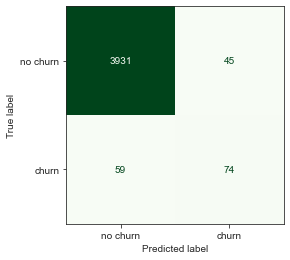

In [228]:
cm = ConfusionMatrixDisplay.from_estimator(
    model,
    X_test,
    y_test,
    display_labels=["no churn", "churn"],
    cmap=plt.cm.Greens,
    colorbar=False,
)

# _= cm.plot()
# _= cm.ax_.set_title("Error Matrix", fontsize=14)

In [211]:
joblib.dump(model, os.path.join(path, "salary_2205_hr_xgb_model.pkl"))

['C:\\Users\\pmm\\ownCloud\\jupyter\\22-05 HR\\salary_2205_hr_xgb_model.pkl']

In [218]:
from BorutaShap import BorutaShap, load_data

model = XGBClassifier(**model_params)

Feature_Selector = BorutaShap(
    model=model, importance_measure="shap", classification=True,
)

Feature_Selector.fit(
    X=X_train,
    y=y_train,
    n_trials=100,
    sample=False,
    train_or_test="test",
    normalize=True,
    verbose=True,
)

  0%|          | 0/100 [00:00<?, ?it/s]

6 attributes confirmed important: ['annual_salary', 'Time_In_TDS', 'percent_of_market_after_action', 'pts', 'prev_wage', 'age_at_action']
36 attributes confirmed unimportant: ['x4_POC', 'x5_No', 'x1_51', 'fst_bool', 'promotion_bool', 'Time_In_Payscale', 'urg_current', 'x3_Unknown', 'x1_25', 'x0_Non-Union Emp', 'x2_Wireline', 'x6_Yes', 'x1_24', 'x2_Cable', 'x3_Hispanic/Latino', 'x3_American Indian or Alaskan Native', 'x3_White', 'x1_20', 'commission', 'progression_bool', 'x2_OOT', 'emp_subgroup', 'x3_Native Hawaiian or Other Pacific Islander', 'x6_No', 'x4_Unknown', 'x3_Asian', 'x3_Black or African American', 'x5_Yes', 'x5_Unknown', 'x6_Unknown', 'x1_50', 'x4_Non-POC', 'gender', 'retiree_med', 'x3_Two or More Races', 'hired_bool']
0 tentative attributes remains: []


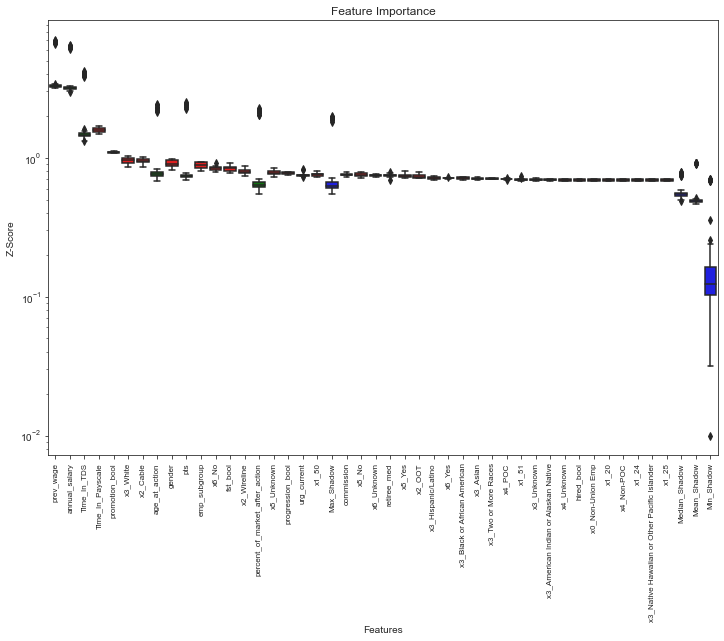

In [230]:
# Returns Boxplot of features
Feature_Selector.plot(which_features="all")

In [229]:
Feature_Selector.Subset().columns

Index(['annual_salary', 'Time_In_TDS', 'percent_of_market_after_action', 'pts',
       'prev_wage', 'age_at_action'],
      dtype='object')

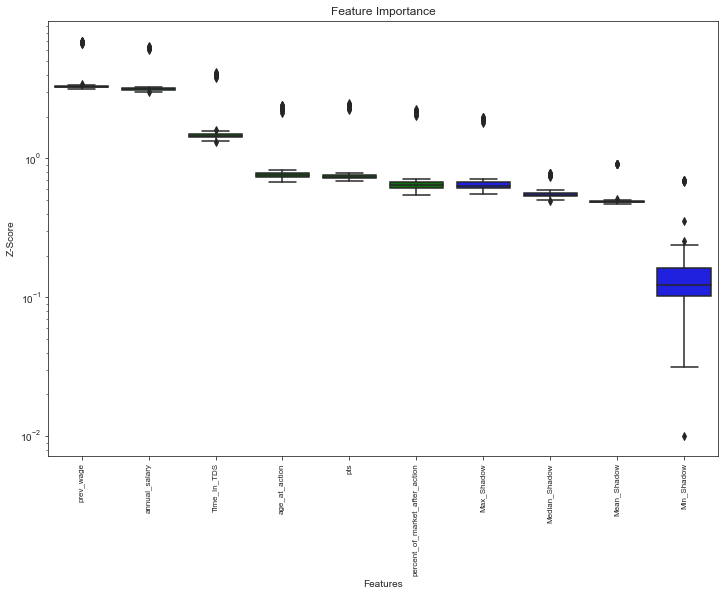

In [220]:
Feature_Selector.plot(which_features="accepted")

In [270]:
# Get list of associates predicted to churn from original df
yt = pd.Series(y_test)
yp = pd.Series(y_pred, index=bar.index)
idx = yp[(yp == True) * (yt == False)].index
df.loc[idx, "pers_no"].to_csv("predicted_churn.csv", index=False)

In [273]:
dfa = pd.read_csv("predicted_churn.csv")

In [276]:
len(df[(df["pers_no"].isin(dfa["pers_no"])) & (df["churned"] == 1)])

32

In [284]:
train_data["pers_no"].nunique()

3929

In [278]:
tt_idx = yp[(yp == True) * (yt == True)].index
tf_idx = yp[(yp == True) * (yt == False)].index
ft_idx = yp[(yp == False) * (yt == True)].index
ff_idx = yp[(yp == False) * (yt == False)].index

In [279]:
df.loc[tt_idx, "pers_no"].nunique()

74

In [280]:
df.loc[tf_idx, "pers_no"].nunique()

43

In [281]:
df.loc[ft_idx, "pers_no"].nunique()

59

In [285]:
df.loc[ff_idx, "pers_no"].nunique()

2426

In [286]:
2426 + 59 + 43 + 74

2602